In [1]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

import seaborn as sns

from xgboost import XGBRegressor

import joblib

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns",None)

In [3]:
sklearn.set_config(transform_output="default")


## 3. Getting data


In [4]:
df = pd.read_csv("data/heart1.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [5]:
X = df.drop(columns='target')
y = df.target.copy()

In [6]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [7]:
print(X_test.shape,y_test.shape)

(205, 13) (205,)


In [8]:
print(X_train.shape,y_train.shape)

(820, 13) (820,)


## 4. Pre-Processing

In [9]:
num_cols = ['age',	'sex',	'cp',	'trestbps',	'chol',	'fbs',	'restecg',	'thalach',	'exang',	'oldpeak',	'slope',	'ca',	'thal']
num_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler())
])

In [10]:
preprocessor = ColumnTransformer(transformers=[
                ("num", num_transformer , num_cols),
])

In [11]:
preprocessor.fit_transform(X_train)

array([[-0.58584022,  0.65465367,  1.008275  , ...,  1.00526437,
         2.17169136, -0.54519316],
       [ 1.05147737, -1.52752523, -0.91672034, ...,  1.00526437,
        -0.7254674 , -0.54519316],
       [-0.04006769, -1.52752523,  1.008275  , ...,  1.00526437,
        -0.7254674 , -0.54519316],
       ...,
       [-0.36753121,  0.65465367, -0.91672034, ...,  1.00526437,
        -0.7254674 ,  1.11057867],
       [-1.24076726,  0.65465367, -0.91672034, ...,  1.00526437,
        -0.7254674 ,  1.11057867],
       [-0.2583767 ,  0.65465367, -0.91672034, ...,  1.00526437,
         0.24025219, -0.54519316]], shape=(820, 13))

## 5. Model Selection


In [12]:
algorithms = {
	"Linear Regression": LinearRegression(),
	"Support Vector Machine": SVR(),
	"Random Forest": RandomForestRegressor(n_estimators=10),
	"XG Boost": XGBRegressor(n_estimators=10)
}

In [13]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [14]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_train,
		y=y_train,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

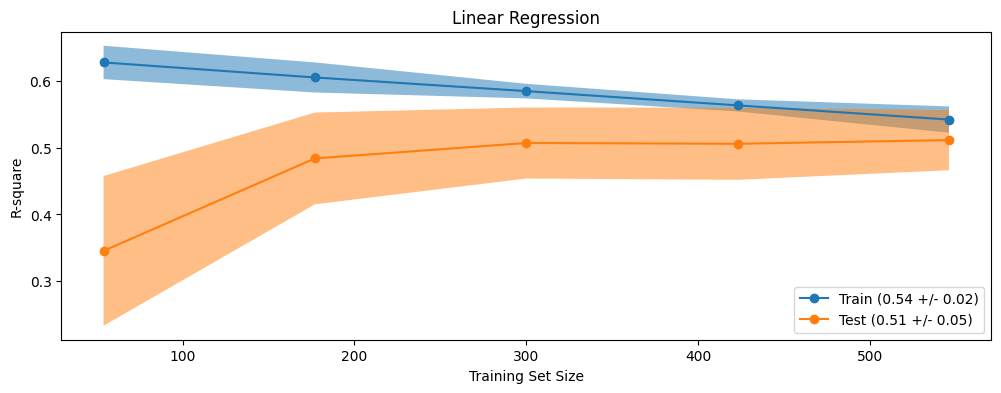

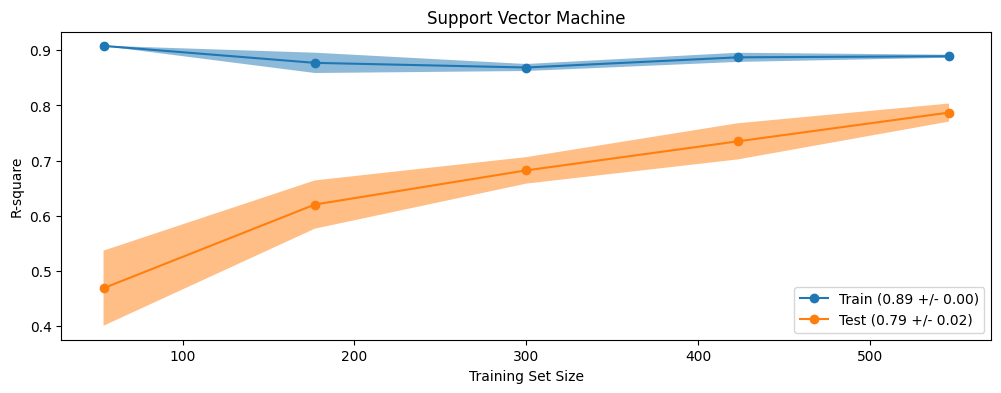

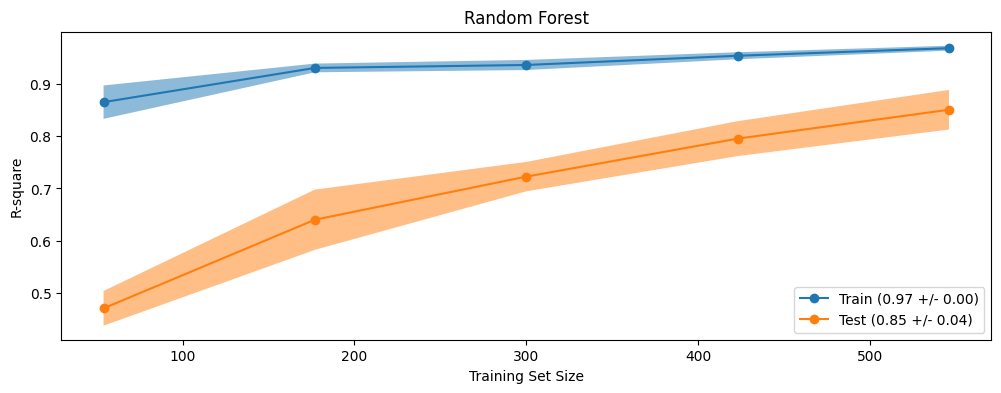

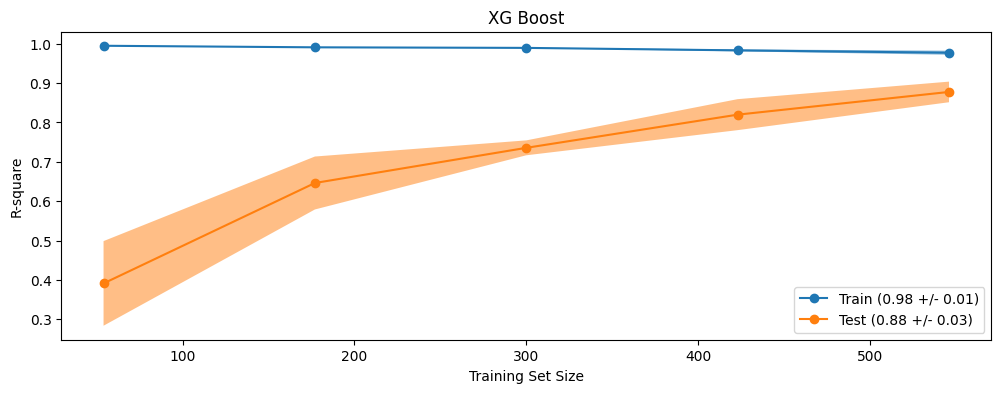

In [15]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

##  6. Model Training


In [16]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [17]:
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sex', 'cp',
                                                   'trestbps', 'chol', 'fbs',
                                                   'restecg', 'thalach',
                                                   'exang', 'oldpeak', 'slope',
                                                   'ca', 'thal'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7. Model Evalutaion

In [18]:
for name, alg in algorithms.items():
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", alg)
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n{name}:")
    print(f"  R²: {r2:.3f}")
    print(f"  MAE: {mae:.3f}")
    print(f"  RMSE: {rmse:.3f}")



Linear Regression:
  R²: 0.410
  MAE: 0.310
  RMSE: 0.384

Support Vector Machine:
  R²: 0.803
  MAE: 0.151
  RMSE: 0.222

Random Forest:
  R²: 0.937
  MAE: 0.057
  RMSE: 0.125

XG Boost:
  R²: 0.893
  MAE: 0.087
  RMSE: 0.163


## 8. Model persistence


In [19]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [20]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'sex', 'cp',
                                                   'trestbps', 'chol', 'fbs',
                                                   'restecg', 'thalach',
                                                   'exang', 'oldpeak', 'slope',
                                                   'ca', 'thal'])])),
                ('alg',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsa...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=10, n_jobs=None,
                              num_parallel_tree=None, ...))])